
Learning a Hamiltonian with Symbolic Regression: preparing the data
===============================================


*Author: Steve Abel*

Note: you require the .venv_Pytorch environment 



In this notebook we use operon to regress the parameteres of a circuit diagram to achieve the require amplitudes



In [28]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
import numpy as np
import pickle

# set the random seed
np.random.seed(42)
import strawberryfields as sf
from strawberryfields import ops
from strawberryfields.ops import *
from strawberryfields import ops

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib import rc

from numpy import linalg as LA

# %matplotlib notebook

plt.rcParams['mathtext.fontset'] = 'cm'  # parameters to get LaTeX in figures 
plt.rc('font', family='serif')
plt.rc('text', usetex=True)


Required Fock amplitudes for a Gaussian of width $\sigma = 1/\pi$ at $x_0=-2$:
------------

What follows is the dump of attempted Fock values etc etc 

   <!-- | Level | Amplitude |
   | :---:   | :---: |
   | 0     | $$1-\frac{19 i t}{32}-\frac{937 t^2}{2048}-\frac{15 t^2 \epsilon }{128}-\frac{15 t^2 \epsilon ^2}{1024}$$ |
   | 1  | $$\frac{3 i t}{4 \sqrt{2}}+\frac{153 t^2}{128 \sqrt{2}}+\frac{3 i t \epsilon }{16\sqrt{2}}+\frac{153 t^2 \epsilon }{512 \sqrt{2}}$$ |
   | 2  | $$-\frac{3 i t}{8 \sqrt{2}}-\frac{385 t^2}{256 \sqrt{2}}-\frac{45 t^2 \epsilon }{64 \sqrt{2}}-\frac{45 t^2 \epsilon ^2}{512 \sqrt{2}}$$ |
   | 3  | $$\frac{1}{4} i \sqrt{3} t+\frac{121 \sqrt{3} t^2}{128}+\frac{1}{16} i \sqrt{3} t \epsilon+\frac{121}{512} \sqrt{3} t^2 \epsilon$$ |
   | 4  | $$-\frac{1}{8} i \sqrt{\frac{3}{2}} t-\frac{361}{256} \sqrt{\frac{3}{2}} t^2-\frac{15}{32}\sqrt{\frac{3}{2}} t^2 \epsilon -\frac{15}{256} \sqrt{\frac{3}{2}} t^2 \epsilon ^2$$ |
   | 5  | $$\frac{21 \sqrt{15} t^2}{64}+\frac{21}{256} \sqrt{15} t^2 \epsilon$$ |
   | 6  | $$-\frac{45}{128} \sqrt{5} t^2-\frac{3}{32} \sqrt{5} t^2 \epsilon -\frac{3}{256} \sqrt{5}t^2 \epsilon ^2$$ |
   | 7  | $$\frac{3}{32} \sqrt{\frac{35}{2}} t^2+\frac{3}{128} \sqrt{\frac{35}{2}} t^2 \epsilon$$ |
   | 8  | $$-\frac{3}{128} \sqrt{\frac{35}{2}} t^2$$  | 
    -->

In [29]:

def ground_amps(n):
   out = np.array([ 0+0j for p in range(n)])
   out[0]= 1+0j
   return out 

simon_amps =[-0.47227375+0.46122749j ,-0.04646713-0.12176082j ,-0.00323399-0.35827263j,
  0.31235071-0.01098741j,  0.13089182+0.25144218j, -0.22036681+0.22454736j,
 -0.21345255-0.08403835j, -0.02083858-0.21518621j , 0.09498175-0.06000955j,
  0.06498938+0.01897853j,  0.04247121-0.02325649j,  0.07036498+0.03118022j,
  0.00768318+0.06998999j, -0.0370873 +0.03077685j,  0.00967176+0.03296652j,
 -0.0359663 +0.04061022j, -0.0356157 -0.00783735j, -0.0099539 -0.01173948j,
 -0.0437539 +0.00467227j, -0.02483004-0.0385767j ]

displaced_gaussian_amps= [ 0.20293326, -0.43539227 , 0.58633034 , -0.5424636 ,  0.31935802 , -0.05553126,
 -0.10211025 , 0.10938814, -0.03358561, -0.02930975 , 0.03636134 , -0.00907124,
 -0.0123835 ,  0.01187552, -0.00063903, -0.00557851]



# circuite parameters to displace the Gaussian for the SHO - multiply reals by 5 and phases by 2Pi (BS are both 2Pi)
DR0 =     0.5
DR1 =     0.37450567
DR2 =     0.25179502
DI0 =     0.0
DI1 =     0.052711308
DI2 =     0.39222488
SR0 =     0.45402896
SR1 =     0.18553424
SR2 =     0.23669632
SI0 =     0.41815495
SI1 =     0.99757224
SI2 =     0.34090436
BR0 =     0.9647039
BR1 =     0.8027184
BR2 =     0.38772732
BI0 =     0.3605792
BI1 =     0.99248
BI2 =     0.86659706
FR1 =     0.025402837
FI1 =     0.48862028
Rot =     0.3

D0=DR0+DI0*1j
D1=DR1+DI1*1j
D2=DR2+DI2*1j
S0=SR0+SI0*1j
S1=SR1+SI1*1j
S2=SR2+SI2*1j
BS0=BR0+BI0*1j
BS1=BR1+BI1*1j
BS2=BR2+BI2*1j
SF=FR1+FI1*1j



**In the next cell I define the class to generate a training set of amplitudes from a certain set of parameters**

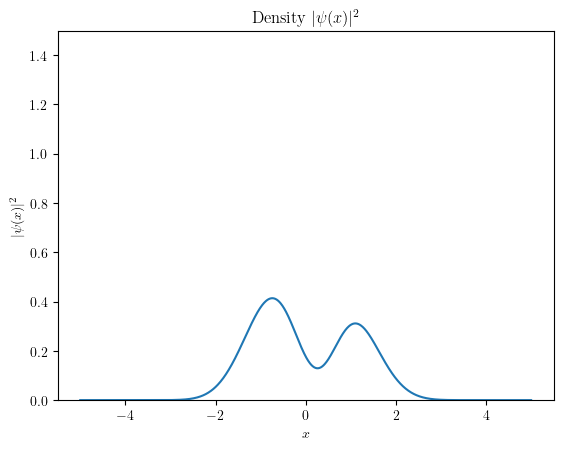

Check I can initialize the state correctly in a pure Fock state


/Users/sabel/.venv_Pytorch/lib/python3.11/site-packages/strawberryfields/program.py:732: UserWarning: The circuit consists of 2 disconnected components.


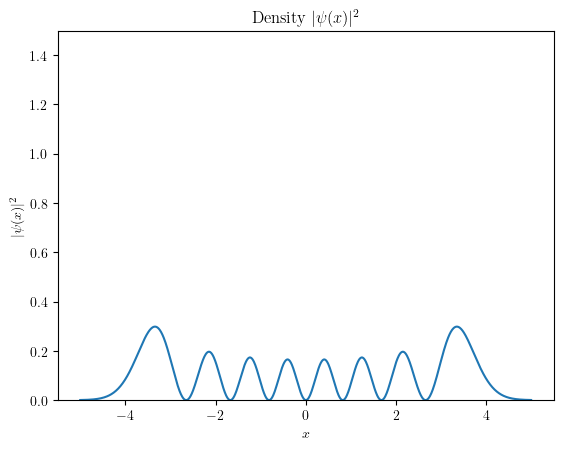

In [35]:
import math as mt
import scipy as sc
from scipy import special
import matplotlib.pyplot as plt
import numpy as np

SHO_params =     [D0,D1,D2,S0,S1,S2,BS0,BS1,BS2,SF] # take 10 complex parameters for this circuit 
default_params = [D0,D1,D2,S0,S1,S2,BS0,BS1,BS2,SF] # take 10 complex parameters for this circuit 
displaced_gaussian_params =  [D0,D1,D2,BS0,SF,Rot]

class State:
    
    def __init__(self, amps, _op='', label = ''): #attributes ==>
        ''' psi = State([Complex(0,0),Complex(0,0),Complex(0,0), .. ,Complex(1,0)]  <== the state is defined like this  '''
        self.len = len(amps)
        self.amps = amps 
        self.probs = np.real_if_close( self.amps * np.conj(self.amps) )
        self._op = _op
        self.label = label 
         
    def __init__(self, amps, _op='', label = ''): #attributes ==>
        ''' psi = State([Complex(0,0),Complex(0,0),Complex(0,0), .. ,Complex(1,0)]  <== the state is defined like this  '''
        self.len = len(amps)
        self.amps = amps 
        self.probs = np.real_if_close( self.amps * np.conj(self.amps) )
        self._op = _op
        self.label = label 
         
    def __repr__(self):
        return f"State(amps={self.amps})"
    
    def __add__(self,other):  #add two states ==>
        out = State(self.amps + other.amps, (self,other), '+')
        return out   
    
    def __neg__(self):
        return State(-self.amps)

    def __sub__(self,other):
        return self + (-other)  # uses - as the symbol but treats them as State objects 

    def Herm(self,n,x):
       return sc.special.hermite(n, monic=False)(x)
    
    def Nn(self,n):
       return 1/np.sqrt(2.0**n * mt.factorial(n) )
 
    def phi(self,m,x):
       c0 = np.pi ** (-0.25)
       return c0 * self.Nn(m) * self.Herm(m,x) * np.exp(-x**2/2.0 ) 

    def __call__(self,x): # returns state as a function of x
        out = sum( ( self.amps[m]*self.phi(m,x) for m in range(self.len)))  
        return out 
    
    def dens(self,x): # returns density as a function of x
        out = sum( ( self.amps[m]*self.phi(m,x) for m in range(self.len)))  
        return out 
    
    def amp_extract(self,result_):
        if result_.shape == (self.len,):  # adjust to take account of output possibly being just amplitudes or a 
            the_amps = result_
        else:
            density_matrix = result_
            eigenvalues, eigenvectors =  LA.eig(density_matrix) 
            unit_idxs = np.where( abs(eigenvalues - 1.0)<0.0000001)[0]  
              # if the state is pure, then the pure state is the eigenvector that has eigenvalue 1 for the density_matrix 
              # because rho = |\psi ><\psi | => rho|psi> = |\psi ><\psi | \psi> =  | \psi> 
            if len(unit_idxs)==0:
              print("Oh dear - not pure state - I'm about to fall over because no unit eigenvalue. Density Matrix =", density_matrix)       
            unit_idx = unit_idxs[0]
            the_amps =  np.real_if_close(eigenvectors[unit_idx])
        self.amps = the_amps
        self.probs = np.real_if_close( the_amps * np.conj(the_amps) )
        return self.amps, self.probs

    def evolve_SHO(self,trotters=1, pms = SHO_params):
        eng = sf.Engine("fock", backend_options={"cutoff_dim": self.len}) # note the cut-off dim itself does not appear
        if eng.run_progs: 
            eng.reset()  # zeros it to a ground state and removes any information the engine is holding 
        hami_simulation = sf.Program(3) 
        with hami_simulation.context as q:
          # prepare the initial state 

          # Fock(2) | q[0]   
         
          Dgate( 5*pms[0].real, 2*np.pi*pms[0].imag ) | q[0]
          Dgate( 5*pms[1].real, 2*np.pi*pms[1].imag ) | q[1]
          Dgate( 5*pms[2].real, 2*np.pi*pms[2].imag ) | q[2]
  
          Sgate( 5*pms[3].real, 2*np.pi*pms[3].imag ) | q[0] # or     Sgate( s0, phi ) | q[0] if there is a phase 
          Sgate( 5*pms[4].real, 2*np.pi*pms[4].imag ) | q[1]
          Sgate( 5*pms[5].real, 2*np.pi*pms[5].imag ) | q[2]

          BSgate(2*np.pi*pms[6].real, 2*np.pi*pms[6].imag ) | (q[0], q[1])
          BSgate(2*np.pi*pms[7].real, 2*np.pi*pms[7].imag ) | (q[1], q[2])
          BSgate(2*np.pi*pms[8].real, 2*np.pi*pms[8].imag) | (q[0], q[1])

          Sgate( 5*pms[9].real, 2*np.pi*pms[9].imag ) | q[2]

          MeasureFock(select = 1) |q[0]
          MeasureFock(select = 2) |q[1]

          for i in range(trotters):
             Rgate( 0.02 ) | q[2]

        result = eng.run(hami_simulation)
        the_state = result.state
        result_ = np.array(the_state.data[0][0])
        test_amps , test_probs = self.amp_extract(result_)

    def evolve_short(self, Start=0 , trotters=1, pms = displaced_gaussian_params):
        eng = sf.Engine("fock", backend_options={"cutoff_dim": self.len}) # note the cut-off dim itself does not appear
        if eng.run_progs: 
            eng.reset()  # zeros it to a ground state and removes any information the engine is holding 
       
        hami_simulation = sf.Program(2) 
        with hami_simulation.context as q:
          # prepare the initial state 

          Fock(Start)              | q[1]   # why does this not make a difference ???
          Fock(0)                  | q[0]
          
          # Dgate( 5*pms[0].real, 2*np.pi*pms[0].imag ) | q[1]   # initial displacement 
                   #[D0,D1,D2,BS0,SF,Rot]

          for i in range(trotters):
            
            Dgate( 5*pms[1].real, 2*np.pi*pms[1].imag ) | q[0]
            Dgate( 5*pms[2].real, 2*np.pi*pms[2].imag ) | q[1]
            BSgate(2*np.pi*pms[3].real, 2*np.pi*pms[3].imag ) | (q[0], q[1])
            Sgate( 5*pms[4].real, 2*np.pi*pms[4].imag ) | q[1] # or     Sgate( s0, phi ) | q[0] if there is a phase 
         
            Rgate( pms[5].real ) | q[1]

            MeasureFock(select = 1) |q[0]
        
        result = eng.run(hami_simulation)
        the_state = result.state
        result_ = np.array(the_state.data[0][0])
        self.amps , self.probs = self.amp_extract(result_)
        
    def evolve(self,trotters=1, pms = default_params):
        eng = sf.Engine("fock", backend_options={"cutoff_dim": self.len}) # note the cut-off dim itself does not appear
        if eng.run_progs: 
            eng.reset()  # zeros it to a ground state and removes any information the engine is holding 
        hami_simulation = sf.Program(3) 
        with hami_simulation.context as q:
          # prepare the initial state
          #Fock(1) | q[0]    # why does this not make a difference ???
          for i in range(trotters):  
            
             Dgate( pms[0].real, pms[0].imag ) | q[0]
             Dgate( pms[1].real, pms[1].imag ) | q[1]
             Dgate( pms[2].real, pms[2].imag ) | q[2]
  
             Sgate( pms[3].real, pms[3].imag ) | q[0] # or     Sgate( s0, phi ) | q[0] if there is a phase 
             Sgate( pms[4].real, pms[4].imag ) | q[1]
             Sgate( pms[5].real, pms[5].imag ) | q[2]

             BSgate(pms[6].real, pms[6].imag ) | (q[0], q[1])
             BSgate(pms[7].real, pms[7].imag ) | (q[1], q[2])
             BSgate(pms[8].real, pms[8].imag) | (q[0], q[1])

             Sgate( pms[9].real, pms[9].imag ) | q[2]

             MeasureFock(select = 1) |q[0]
             MeasureFock(select = 2) |q[1]
      
        result = eng.run(hami_simulation)
        the_state = result.state
        result_ = np.array(the_state.data[0][0])
        self.amps , self.probs = self.amp_extract(result_)

    def evolve_iter(self,trotters=1, pms = default_params): # this version inputs the previous trotter step -- this crashes at the moment - Don't use 
      for i in range(trotters):    
        eng = sf.Engine("fock", backend_options={"cutoff_dim": self.len}) # note the cut-off dim itself does not appear
        if eng.run_progs:    
            eng.reset()  # zeros it to a ground state and removes any information the engine is holding 
        hami_simulation = sf.Program(3) 
        with hami_simulation.context as q:
             sf.ops.Ket(np.array(state.amps)) | q[2]    # prepare the initial state
             
             Dgate( pms[0].real, pms[0].imag ) | q[0]
             Dgate( pms[1].real, pms[1].imag ) | q[1]
             Dgate( pms[2].real, pms[2].imag ) | q[2]
  
             Sgate( pms[3].real, pms[3].imag ) | q[0] # or     Sgate( s0, phi ) | q[0] if there is a phase 
             Sgate( pms[4].real, pms[4].imag ) | q[1]
             Sgate( pms[5].real, pms[5].imag ) | q[2]

             BSgate(pms[6].real, pms[6].imag ) | (q[0], q[1])
             BSgate(pms[7].real, pms[7].imag ) | (q[1], q[2])
             BSgate(pms[8].real, pms[8].imag) | (q[0], q[1])

             Sgate( pms[9].real, pms[9].imag ) | q[2]

             MeasureFock(select = 1) |q[0]
             MeasureFock(select = 2) |q[1]
        result = eng.run(hami_simulation)
        the_state = result.state
        the_amps = the_state.data[0][0]
        self.amps = the_amps    

    def fock_probs(self): 
        '''returns probabilities '''
        amplitudes = self.amps
        return [p * np.conj(p) for p in amplitudes]

    def hist_fock_probs(self): 
        '''plots fock probabßilities '''
        xs = [ i for i in range(self.len)]
        ys = self.fock_probs()
        plt.bar(xs, ys)
        plt.title("Fock probabilities $|A_n|^2$")
        plt.xlabel("$n$")
        plt.ylabel("$|A_n|^2$")
        plt.show()   
    
    def plot(self): 
        '''returns density as a function of x'''
        
        xs = np.arange(-5,5,0.01)
        ys = self(xs)  # thanks to __call__ we can now refer to state4(x) as a function
        plt.plot(xs, ys)
        plt.title("Wave function $\\psi(x)$")
        plt.xlabel("$x$")
        plt.ylabel("$\\psi(x)$")
        plt.show()   
        return 
    
    def save_fig(self,t): 
        '''saves density plot as a function of x'''
        
        xs = np.arange(-5,5,0.01)
        ys = np.real_if_close(self(xs)* np.conj(self(xs)))
        plt.plot(xs, ys)
        plt.ylim(0, 1)
        plt.title("Density $|\\psi(x)|^2$")
        plt.xlabel("$x$")
        plt.ylabel("$|\\psi(x)|^2$")
        plt.savefig('Frames/foo'+str(p)+'.png')
        plt.close()
        return 

    def plot_dens(self): 
        '''returns density as a function of x'''
        
        xs = np.arange(-5,5,0.01)
        ys = np.real_if_close(self(xs)* np.conj(self(xs)))
        plt.plot(xs, ys)
        plt.ylim(0, 1.5)
        plt.title("Density $|\\psi(x)|^2$")
        plt.xlabel("$x$")
        plt.ylabel("$|\psi(x)|^2$")
        plt.show()   
        return 
#examples of usage
#state1 = State(amps)
#state2 = State(amps2) 
#state3=state1-state2
#state4=state1+state2
# didn't bother with __mul__ for scalar multiplication but this would have been one way to do things. 
wave_func = State(ground_amps(8)) # for the displaced gaussian this has to be the number of fock states it was trained on
wave_func.evolve(trotters=1 )
wave_func.plot_dens()
print("Check I can initialize the state correctly in a pure Fock state")
wave_func.evolve_short( Start = 7 , trotters=0 )
wave_func.plot_dens()

# Now generate data points 

Next prepare the data - a whole load of random parameters and resulting amplitudes ...

In [54]:

ranges = [[0.1, 0] ,[ 0, 0.1] ]
# [D0,D1,D2,BS0,SF,Rot] # make them all complex 
amplitudes = []
circuit_params =[]
#[[0.0 for i in range(3*trunc+2*param_nums)]]
trunc = 8
param_nums = 6


def data_generate(points):  
  fock_numbers = np.random.randint(trunc,size=points)
  fock_numbers = [0 for i in range(points)]
  
  count=0
  data_to_save = []
  for p in fock_numbers:
     count +=1
     this_circuit_params = np.array(np.random.rand(param_nums,2) @ ranges) # real and phases
     params = [ this_circuit_params[i][0] + this_circuit_params[i][1]* 1j for i in range(param_nums)] 
  
     state1 = State(ground_amps(trunc))

     try:
        data_entry =  [ 1 if i == p else 0 for i in range(trunc)]
        state1.evolve_short( Start = p , trotters=1, pms = params )
        this_amplitudes = state1.amps
     
        
        for k in params:
           data_entry.append(k.real)
           data_entry.append(k.imag)

        for k in this_amplitudes:
           data_entry.append(k.real)
           data_entry.append(k.imag)

        if len(data_to_save) == 0:
           data_to_save = [data_entry] 
        else: 
           data_to_save.append(data_entry) 
          
     except Exception:
        #print("Divison by zero")
        pass
  print("Points count = ",count)
  return np.array(data_to_save)


In [55]:

training_data = data_generate(100000)
validation_data = data_generate(100000)


pickle.dump(training_data, open("Data/training.dat", "wb" ))
pickle.dump(validation_data, open("Data/validation.dat", "wb" ))
print("Done !")
         

Points count =  100000
Points count =  100000
Done !
